Now that we have tiles in a processed format, build up some utilities for scanning tiles and discovering features about them.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy import ndimage
from scipy.interpolate import griddata

%matplotlib inline

In [2]:
prefix = "processed_tiles/"

def th(leftTerrain, leftCrowns, rightTerrain, rightCrowns):
    tt = ["desert", "forest", "ocean", "grass", "swamp", "mine"]
    assert (leftTerrain in tt )
    assert (rightTerrain in tt )
    assert (leftCrowns in [0, 1, 2, 3])
    assert (rightCrowns in [0, 1, 2, 3])
    return {
        "left_terrain": leftTerrain,
        "left_crowns": leftCrowns,
        "right_terrain": rightTerrain,
        "right_crowns": rightCrowns
    }

# These are manually created labels
whole_tiles = {
    "01": th("desert", 0, "desert", 0),
    "02": th("desert", 0, "desert", 0),
    "03": th("forest", 0, "forest", 0),
    "04": th("forest", 0, "forest", 0),
    "05": th("forest", 0, "forest", 0),
    "06": th("forest", 0, "forest", 0),
    "07": th("ocean", 0, "ocean", 0),
    "08": th("ocean", 0, "ocean", 0),
    "09": th("ocean", 0, "ocean", 0),
    "10": th("grass", 0, "grass", 0),
    "11": th("grass", 0, "grass", 0),
    "12": th("swamp", 0, "swamp", 0),
    "13": th("desert", 0, "forest", 0),
    "14": th("desert", 0, "ocean", 0),
    "15": th("desert", 0, "grass", 0),
    "16": th("desert", 0, "swamp", 0),
    "17": th("forest", 0, "ocean", 0),
    "18": th("forest", 0, "grass", 0),
    "19": th("desert", 1, "forest", 0),
    "20": th("desert", 1, "ocean", 0),
    "21": th("desert", 1, "grass", 0),
    "22": th("desert", 1, "swamp", 0),
    "23": th("desert", 1, "mine", 0),
    "24": th("forest", 1, "desert", 0),
    "25": th("forest", 1, "desert", 0),
    "26": th("forest", 1, "desert", 0),
    "27": th("forest", 1, "desert", 0),
    "28": th("forest", 1, "ocean", 0),
    "29": th("forest", 1, "grass", 0),
    "30": th("ocean", 1, "desert", 0),
    "31": th("ocean", 1, "desert", 0),
    "32": th("ocean", 1, "forest", 0),
    "33": th("ocean", 1, "forest", 0),
    "34": th("ocean", 1, "forest", 0),
    "35": th("ocean", 1, "forest", 0),
    "36": th("desert", 0, "grass", 1),
    "37": th("ocean", 0, "grass", 1),
    "38": th("desert", 0, "swamp", 1),
    "39": th("grass", 0, "swamp", 1),
    "40": th("mine", 1, "desert", 0),
    "41": th("desert", 0, "grass", 2),
    "42": th("ocean", 0, "grass", 2),
    "43": th("desert", 0, "swamp", 2),
    "44": th("grass", 0, "swamp", 2),
    "45": th("mine", 2, "desert", 0),
    "46": th("swamp", 0, "mine", 2),
    "47": th("swamp", 0, "mine", 2),
    "48": th("desert", 0, "mine", 3)
}

for i in range(1, 49):
    filename = prefix + "cropped_tile_"
    
    key = str(i)
    if (i < 10): key = "0" + key
    
    filename += key + ".png"
    
    print(filename)
    tile = cv2.imread(filename)
    tile = cv2.cvtColor(tile, cv2.COLOR_BGR2RGB)

    whole_tiles[key]["image_path"] = filename
    whole_tiles[key]["image"] = tile
    whole_tiles[key]["intensity"] = cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY)

processed_tiles/cropped_tile_01.png
processed_tiles/cropped_tile_02.png
processed_tiles/cropped_tile_03.png
processed_tiles/cropped_tile_04.png
processed_tiles/cropped_tile_05.png
processed_tiles/cropped_tile_06.png
processed_tiles/cropped_tile_07.png
processed_tiles/cropped_tile_08.png
processed_tiles/cropped_tile_09.png
processed_tiles/cropped_tile_10.png
processed_tiles/cropped_tile_11.png
processed_tiles/cropped_tile_12.png
processed_tiles/cropped_tile_13.png
processed_tiles/cropped_tile_14.png
processed_tiles/cropped_tile_15.png
processed_tiles/cropped_tile_16.png
processed_tiles/cropped_tile_17.png
processed_tiles/cropped_tile_18.png
processed_tiles/cropped_tile_19.png
processed_tiles/cropped_tile_20.png
processed_tiles/cropped_tile_21.png
processed_tiles/cropped_tile_22.png
processed_tiles/cropped_tile_23.png
processed_tiles/cropped_tile_24.png
processed_tiles/cropped_tile_25.png
processed_tiles/cropped_tile_26.png
processed_tiles/cropped_tile_27.png
processed_tiles/cropped_tile

In [3]:
half_tiles = {}
for key, tile in whole_tiles.items():
    t = key + "_L"
    half_tiles[t] = {
            "terrain": tile["left_terrain"],
            "crowns": tile["left_crowns"],
            "image": tile["image"][:, 0:128].copy(),
            "intensity": tile["intensity"][:, 0:128].copy()
        }
    t = key + "_R"
    half_tiles[t] = {
            "terrain": tile["right_terrain"],
            "crowns": tile["right_crowns"],
            "image": tile["image"][:, 128:].copy(),
            "intensity": tile["intensity"][:, 128:].copy()
        }

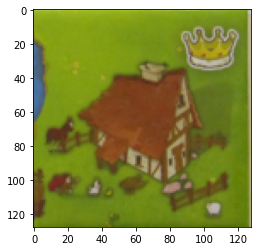

In [5]:
plt.imshow(half_tiles["37_R"]["image"])

In [6]:
s = np.mean(half_tiles["37_L"]["image"], axis = 0)
t = np.mean(s, axis = 0)
print(t)

[ 73.83148193 101.66326904 131.91192627]


We need to figure out a way to classify tiles, knowing that the pictures wont be as good as our tiles here.  I will see if can use average RGB or maybe even distribution of RGB within a title to do this.   Probably a CNN would be simplest, but it also seems like overkill.

In [7]:
avg_array = np.zeros((96, 4))  

terrainToInt = {
    "desert": 0,
    "forest": 1,
    "ocean": 2,
    "grass": 3,
    "swamp": 4,
    "mine": 5
}
    

row = 0
for key, tile in half_tiles.items():
    avg = np.mean(np.mean(tile["image"], axis = 0), axis = 0)
    avg_array[row, 0:3] = avg
    avg_array[row, 3] = terrainToInt[tile["terrain"]]
    row = row + 1

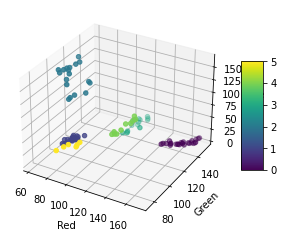

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

plot = ax.scatter(avg_array[:,0], avg_array[:,1], avg_array[:,2], c=avg_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()


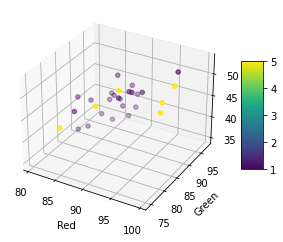

In [9]:
subset = avg_array[np.logical_or(avg_array[:, 3]==1, avg_array[:, 3]==5)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

plot = ax.scatter(subset[:,0], subset[:,1], subset[:,2], c=subset[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

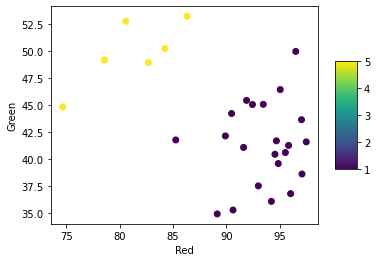

In [10]:
subset = avg_array[np.logical_or(avg_array[:, 3]==1, avg_array[:, 3]==5)]

fig = plt.figure()
ax = fig.add_subplot(111)


plot = ax.scatter(subset[:,1], subset[:,2], c=subset[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

Averages look good except for forest and mines which might require a 2nd pass.   Let's try it out

In [11]:
# Roll up each cluster to an average
clusters = np.zeros((6,3))
for i in range(6):
    clusters[i] = np.mean(avg_array[avg_array[:, 3] == i], axis = 0)[0:3]
print(clusters)

[[161.48790095 141.80672983  10.09729473]
 [ 85.94123424  93.49039529  41.31753817]
 [ 74.23682319 107.92738851 138.87711249]
 [117.44718715 137.31491961  30.39860317]
 [124.87008057 110.4710083   65.12401123]
 [ 94.07957967  81.18944295  49.85673014]]


In [12]:
for key, tile in half_tiles.items():
    avg = np.mean(np.mean(tile["image"], axis = 0), axis = 0)
    distance = np.sum((avg - clusters)**2, axis = 1)
    guess = np.where(distance == np.min(distance))[0][0]
    truth = terrainToInt[tile["terrain"]]
    if (truth != guess): print("Tile {0} guess {2} ground truth {3} distance {1}".format(key, distance, guess, truth))
    

Note the above cell had no output, so this means at least with this pristine version of tiles there is no misclassification.

Ok I think distance  to mean cluster will work. I should try on real photos, but I can do that later.   I hard code the constants so I can move this out of a notebook easier later.

In [13]:
def predictTerrain(image, debug = False):
    ccenters = np.array([[161.48790095, 141.80672983, 10.09729473],
                        [85.94123424,  93.49039529,  41.31753817],
                        [74.23682319, 107.92738851, 138.87711249],
                        [117.44718715, 137.31491961,  30.39860317],
                        [124.87008057, 110.4710083,   65.12401123],
                        [ 94.07957967,  81.18944295,  49.85673014]])
    avg = np.mean(np.mean(image, axis = 0), axis = 0)
    distance = np.sum((avg - ccenters)**2, axis = 1)
    guess = np.where(distance == np.min(distance))[0][0]
    
    return {
        "cluster_center": ccenters[guess],
        "avg": avg,
        "distance": distance,
        "guess": guess
    }

Now for crowns.  First I will try to find 0 or 1 crowns; the plan is to handle 2 and 3 crowns as special cases of 1.  

Note that crowns appear in the top corner of the tile when it's oriented right-side up.   We don't have a lot of cues on orientation, so we can't use that--I'll just check every corner of the image.  First let's see if we can use the same distance-to-mean trick to discern crowns.

In [14]:
# 96*4 comes from 48 tiles x 2 halves x 4 corners
crown_array = np.zeros((96*4, 4))

OT = 128 // 3   # (O)ne Third
TT = 2 * OT     # (T)wo Thirds

row = 0
for key, tile in half_tiles.items():
    # If we think of the tile, the tile seems to fit into
    #  teh corners of a grid divided into 3x3 
    # Let's try that
    full = tile["image"]
    for i in range(4):
        if (i == 0): im = full[0:OT, 0:OT]
        elif (i == 1): im = full[0:OT, TT:]
        elif (i == 2): im = full[TT:, TT:]
        else: im = full[TT:, 0:OT]
       
        avg = np.mean(np.mean(im, axis = 0), axis = 0)
        crown_array[row, 0:3] = avg
        
        if (key[-1] == "L" and i == 0): crown_array[row, 3] = tile["crowns"]
        elif (key[-1] == "R" and i == 1): crown_array[row, 3] = tile["crowns"]
        else: crown_array[row, 3] = 0
        row = row + 1

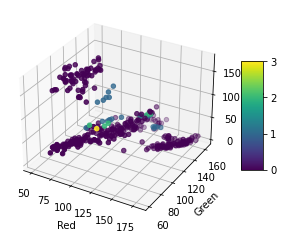

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

plot = ax.scatter(crown_array[:,0], crown_array[:,1], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()


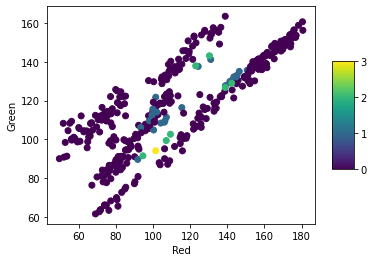

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)

n = 100

plot = ax.scatter(crown_array[:,0], crown_array[:,1], c=crown_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

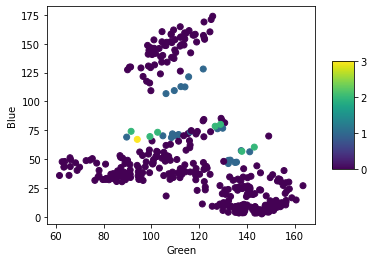

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

n = 100

plot = ax.scatter(crown_array[:,1], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Green')
ax.set_ylabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

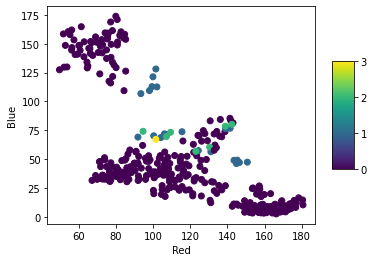

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111)

n = 100

plot = ax.scatter(crown_array[:,0], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

Since the crowns are yellow, let's try adding R+G together to see if that works...

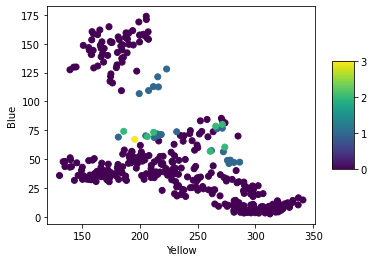

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

n = 100

plot = ax.scatter(crown_array[:,0] + crown_array[:, 1], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Yellow')
ax.set_ylabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

Ok that won't work.  They do seem to be picking up too much background.  I will try subtracting out the cluster center of the predicted tile to try to accentuate the non-normality of the crown.

In [20]:
# 96*4 comes from 48 tiles x 2 halves x 4 corners
crown_array = np.zeros((96*4, 4))

OT = 128 // 3   # (O)ne Third
TT = 2 * OT     # (T)wo Thirds

row = 0
for key, tile in half_tiles.items():
    # If we think of the tile, the tile seems to fit into
    #  teh corners of a grid divided into 3x3 
    # Let's try that
    full = tile["image"]
    predicted_terrain = predictTerrain(full)
    
    for i in range(4):
        if (i == 0): im = full[0:OT, 0:OT]
        elif (i == 1): im = full[0:OT, TT:]
        elif (i == 2): im = full[TT:, TT:]
        else: im = full[TT:, 0:OT]
       
        avg = np.mean(np.mean(im, axis = 0), axis = 0)
        avg = avg - predicted_terrain["cluster_center"]
        crown_array[row, 0:3] = avg
        
        if (key[-1] == "L" and i == 0): crown_array[row, 3] = tile["crowns"]
        elif (key[-1] == "R" and i == 1): crown_array[row, 3] = tile["crowns"]
        else: crown_array[row, 3] = 0
        row = row + 1

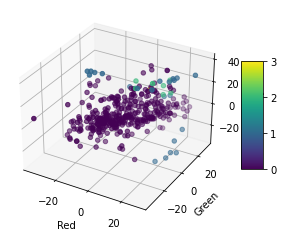

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

plot = ax.scatter(crown_array[:,0], crown_array[:,1], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

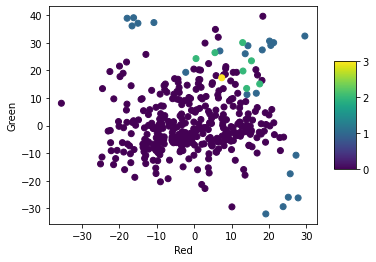

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)

n = 100

plot = ax.scatter(crown_array[:,0], crown_array[:,2], c=crown_array[:,3])

ax.set_xlabel('Red')
ax.set_ylabel('Green')

fig.colorbar(plot, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

That didn't work either. It is changing the color of the crown too which might be the problem.    I will take the average image of each crown and try to use a convolution filter.

<ipython-input-24-8cb1a742b86f>:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


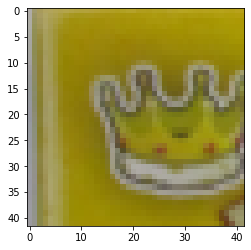

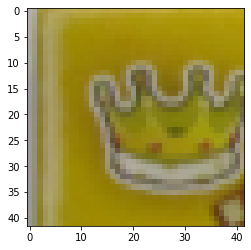

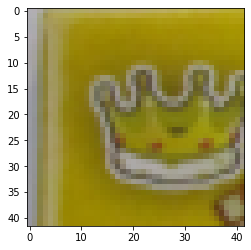

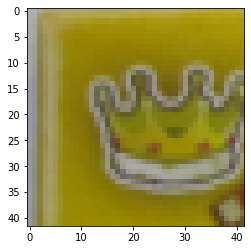

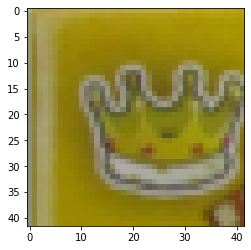

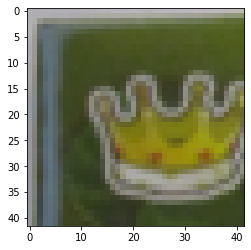

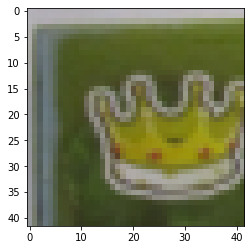

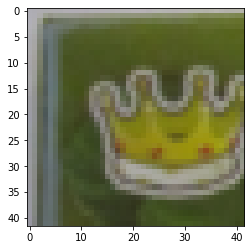

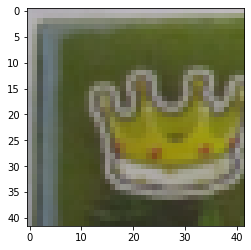

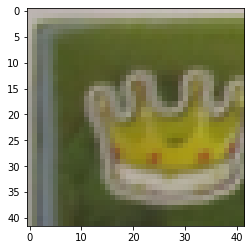

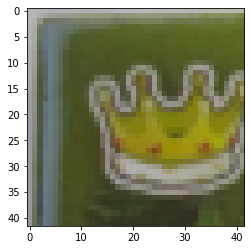

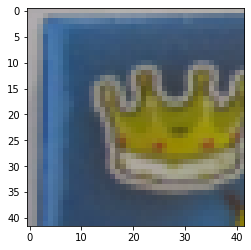

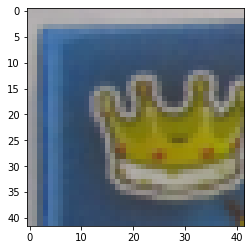

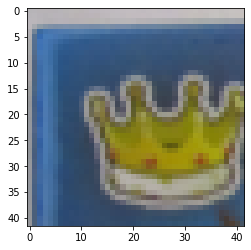

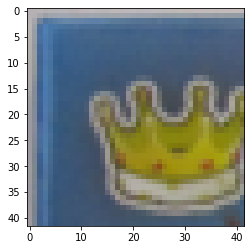

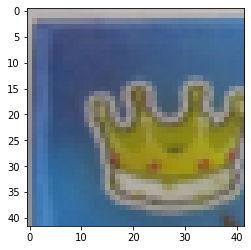

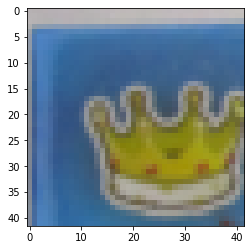

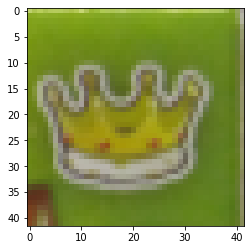

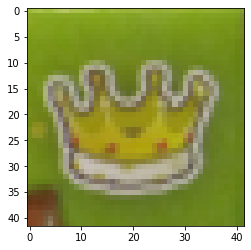

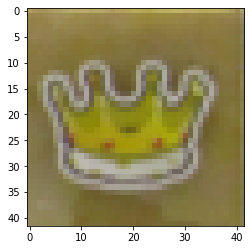

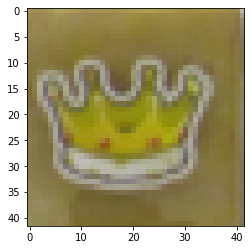

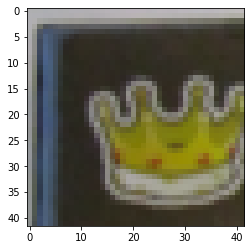

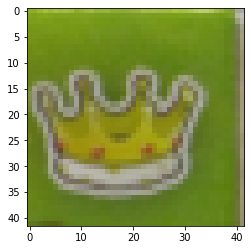

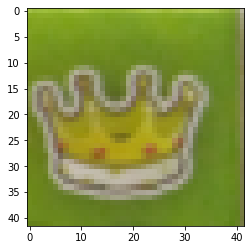

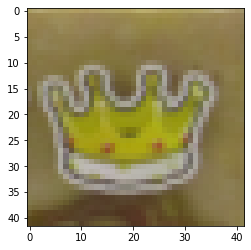

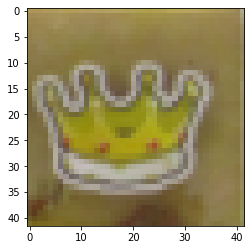

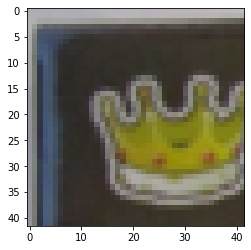

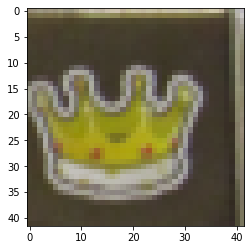

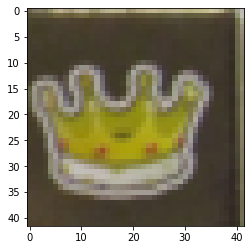

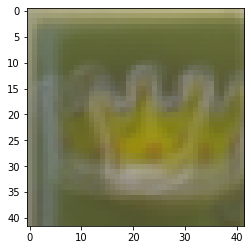

In [24]:
OT = 128 // 3   # (O)ne Third
TT = 2 * OT     # (T)wo Thirds

average_crown = np.zeros((OT, OT, 3))

count = 0
for key, tile in half_tiles.items():
    # If we think of the tile, the tile seems to fit into
    #  teh corners of a grid divided into 3x3 
    # Let's try that
    full = tile["image"]
    predicted_terrain = predictTerrain(full)
    
    for i in range(4):
        if (i == 0): im = full[0:OT, 0:OT]
        elif (i == 1): im = full[0:OT, TT:(TT+OT)]
        elif (i == 2): im = full[TT:(TT+OT):, TT:(TT+OT)]
        else: im = full[TT:, 0:OT]
            
        if (key[-1] == "L" and i == 0 and tile["crowns"] > 0):
            count = count + 1
            plt.figure()
            plt.imshow(im)
            average_crown += im
        elif (key[-1] == "R" and i == 1 and tile["crowns"] > 0):
            count = count + 1
            plt.figure()
            plt.imshow(im)
            average_crown += im

average_crow = average_crown / count
plt.imshow(average_crow.astype('uint8'))

That is not going to work either without another big body of work to align crowns.  I took a processed tile at random, cropped out a crown, cleaned up the edges and removed the background.  Let's import as a filter and see what happens.

In [25]:
crown = cv2.imread("processed_tiles/cropped_crown.png")
crown = cv2.cvtColor(crown, cv2.COLOR_BGR2RGB)
crownbw = cv2.cvtColor(crown, cv2.COLOR_RGB2GRAY)
crown_mask = cv2.imread("processed_tiles/cropped_crown_mask.png").astype('bool').astype('uint8')[:,:,0]

In [43]:
def rescale(image):
    m = np.min(image)
    n = np.max(image)
    if (n == m):
        print(image)
    image = 256 * (image - m) / (n - m)
    return image

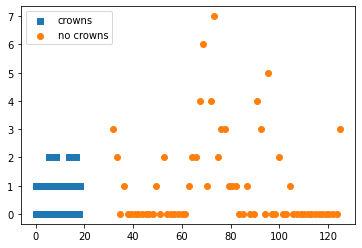

In [106]:
crowns_data = np.zeros(0)
nocrowns_data = np.zeros(0)

# From Mp2 
def cost(I, M, T, debug = False):
    I = I / 255.
    T = T / 255.
    M = M / 1.
    c = np.sum((M*T)**2)
    d = cv2.filter2D(I, ddepth = -1, kernel = M*T) 
    e = cv2.filter2D(I**2, ddepth = -1, kernel = M)
    r = c - 2.0*d + e
    assert(r.shape == I.shape)
    return r

crowns = 0
nocrowns = 0
for key, tile in half_tiles.items():
    TI = tile["image"]
    test = 0
    for c in range(3):
        test = test + cost(TI[:,:,c], crown_mask, crown[:, :, c])

    extreme = np.min(test)
    
    if (tile["crowns"] > 0):
        crowns_data = np.append(crowns_data, extreme)
        crowns = crowns + 1
    else:
        nocrowns_data = np.append(nocrowns_data, extreme)
        nocrowns = nocrowns + 1
        
bins = 64
crowns_hist = np.histogram(crowns_data, bins=bins)
nocrowns_hist = np.histogram(nocrowns_data, bins=bins)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(crowns_hist[1][0:bins], crowns_hist[0], marker="s", label='crowns')
ax1.scatter(nocrowns_hist[1][0:bins], nocrowns_hist[0], marker="o", label='no crowns')
plt.legend(loc='upper left');
plt.show()
    

In [107]:
print(crowns_data.astype('int'))

[13  8 13 12 15 13 16 10  8  7  9 16 18 10 13 11  6  8  5  7  5 16  3  4
  1  0 11  8  5  3]


In [108]:
print(nocrowns_data.astype('int'))

[ 74  91  72  91  66  67  69  77  65  69  70  73 125  86 126  92 126 105
  54  50  67  63  33  32  73  80  72  96  76  77  73  32  64  81  69  68
  72  76  73  33  52  95  96  92  91  78  68  96 100  82  75  70  73  68
 100  78  70  93  72  96  73  69  93  37  31  75]


<ipython-input-113-cc4618081a01>:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


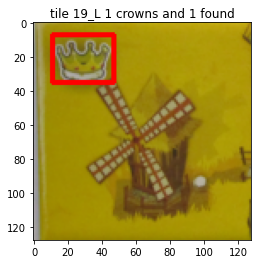

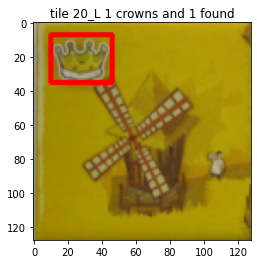

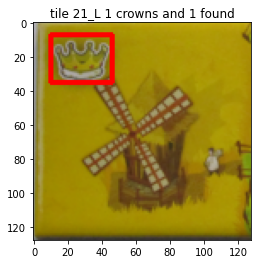

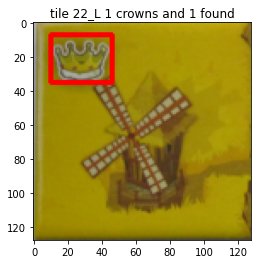

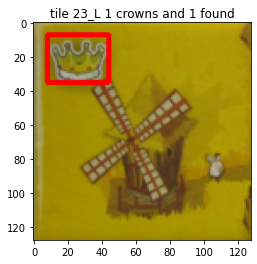

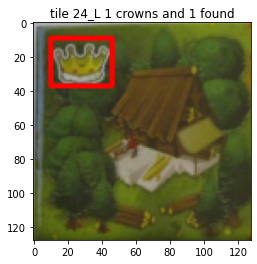

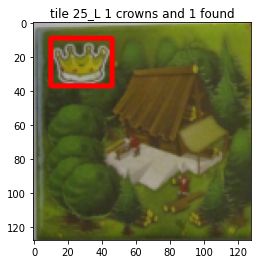

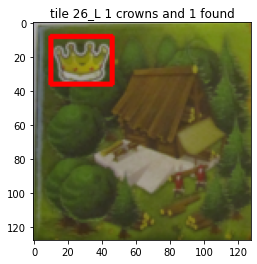

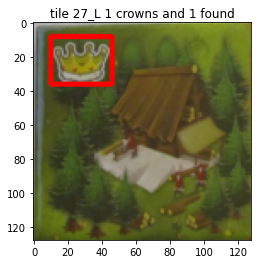

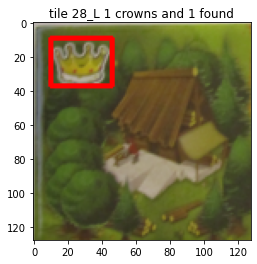

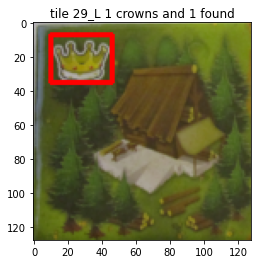

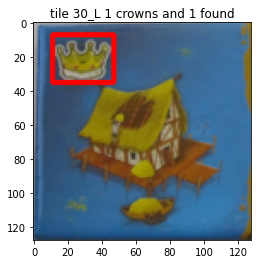

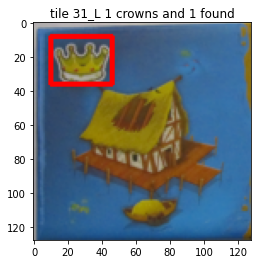

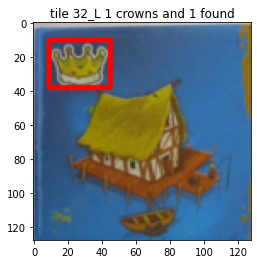

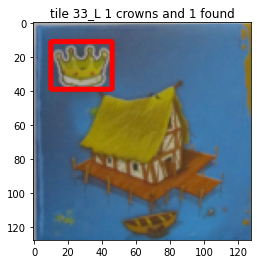

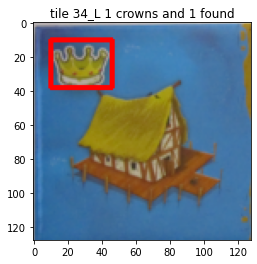

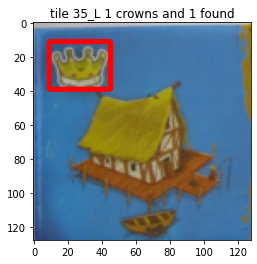

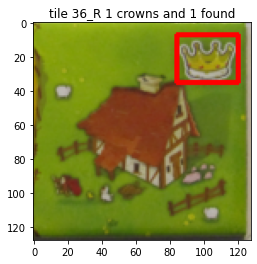

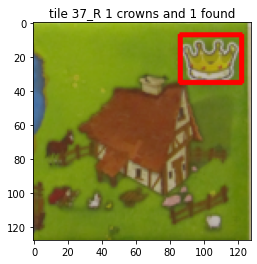

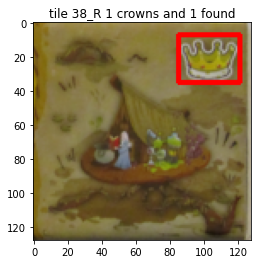

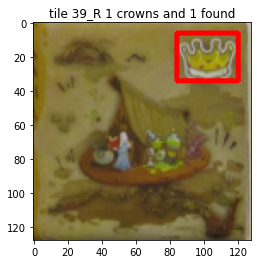

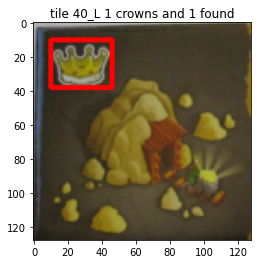

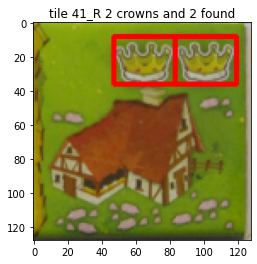

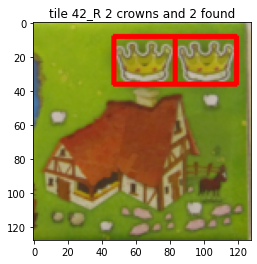

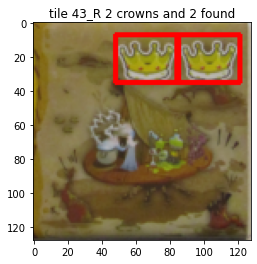

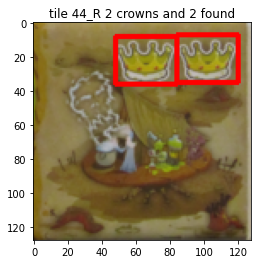

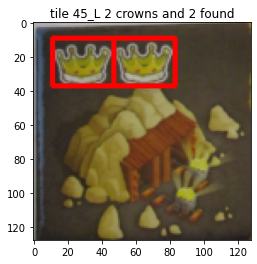

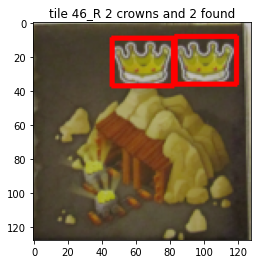

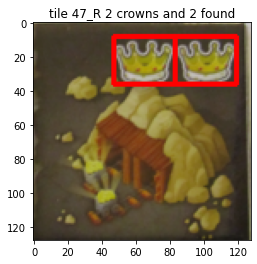

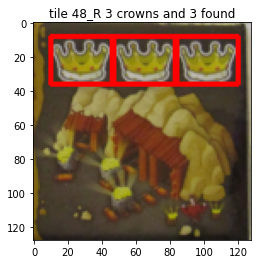

In [113]:
def findCrowns(image, thresh = 30):
    test = 0
    for c in range(3):
        test = test + cost(image[:,:,c], crown_mask, crown[:, :, c])
    idx = np.where(test <= thresh)
    
    # Remove idx that are close together. Use the lowest loss.
    result = []
    for y, x in zip(idx[0], idx[1]):
        
        # Will we add this to our list of candidate crowns?
        new_point = True
        
        # calculate distance to other found centers.
        for i, (yr, xr, loss) in enumerate(result):
            distance = (yr - y)*(yr - y) + (xr - x)*(xr - x)
            if distance < 25:
                new_point = False                
                if test[y, x] < loss:
                    # This new point is close and has a better loss, so replace it.
                    result[i] = (y, x, test[y, x])
                
        
        # If new_point is still tru
        if new_point:
            result.append((y, x, test[y, x]))
    return result 
        
cy, cx = crown.shape[0] // 2, crown.shape[1] // 2

for key, tile in half_tiles.items():
    TI = tile["image"]
    test = 0
    for c in range(3):
        test = test + cost(TI[:,:,c], crown_mask, crown[:, :, c])
    
    crowns = findCrowns(TI)
    
    if (len(crowns) > 0 or len(crowns) != tile["crowns"]):
        TI = TI.copy()
        for y, x, loss in crowns:
            TI = cv2.rectangle(TI, (x - cx, y - cy), (x + cx, y + cy), (255, 0, 0), 2)
    
        plt.figure()
        plt.title("tile {0} {1} crowns and {2} found".format(key, tile["crowns"], len(crowns)))
        plt.imshow(TI)


Ok giving up on classic approach and resorting to machine learning.   I'll use the approach outlined in https://www.cs.cmu.edu/~efros/courses/LBMV07/Papers/viola-cvpr-01.pdf which is also implemented in OpenCV 

In [226]:
def integralImage(image):
    result = np.zeros(image.shape)
    H, W = image.shape
    result[0, 0] = image[0, 0]
    for x in range(1, W):
        result[0, x] = result[0, x - 1] + image[0, x]
    for y in range(1, H):
        result[y, 0] = result[y - 1, 0] + image[y, x]
    
    for y in range(1, image.shape[0]):
        for x in range(1, image.shape[1]):
            result[y, x] = result[y - 1, x] + result[y, x - 1] - result[y - 1, x - 1] + image[y, x]
    
    return result

In [229]:
t = integralImage(half_tiles["33_L"]["intensity"][0:24,0:24] / 255.)

In [231]:
def rectFeature1(integral_image, oy, ox, width, height, sign):
    rect1 = integral_image[oy + height, ox + width] - integral_image[oy, ox]
    rect2 = integral_image[oy + height, ox + 2*width] - integral_image[oy, ox + width]
    return sign*(rect2 - rect1);

In [234]:
example = half_tiles["33_L"]["intensity"].copy()
H, W = example.shape

<ipython-input-241-25e071f6365c>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


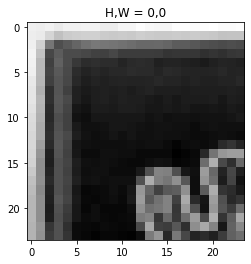

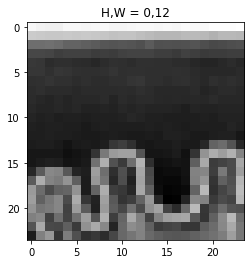

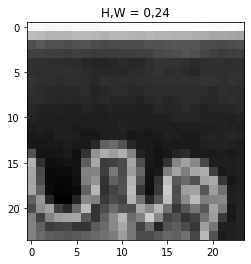

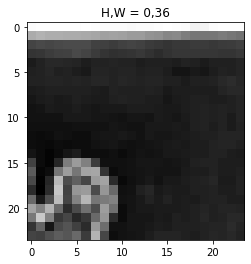

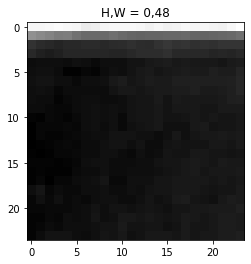

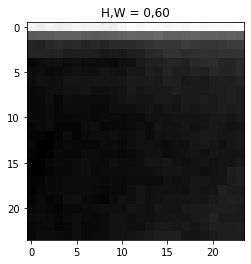

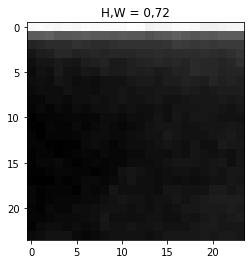

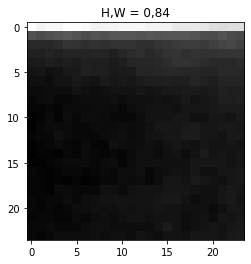

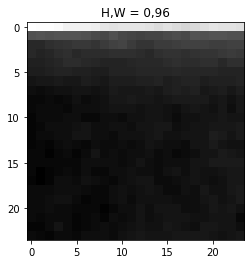

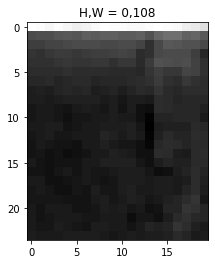

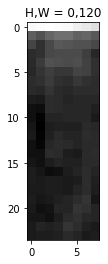

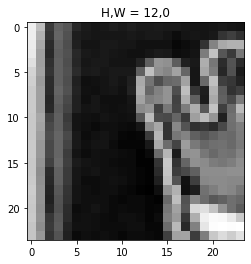

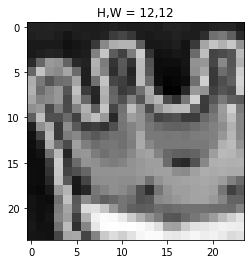

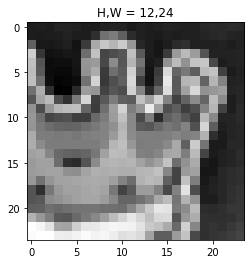

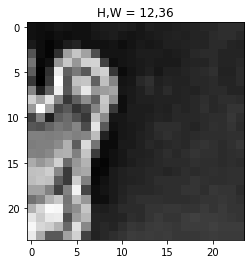

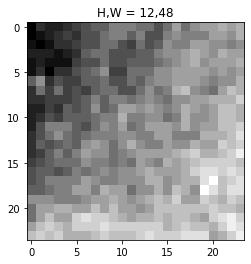

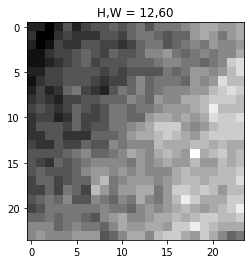

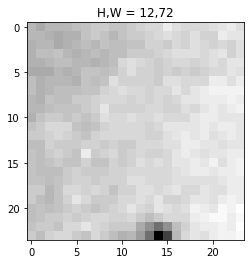

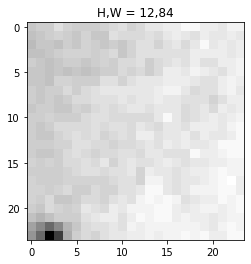

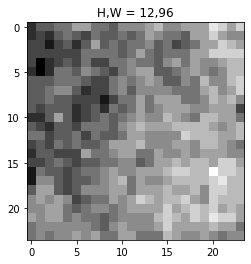

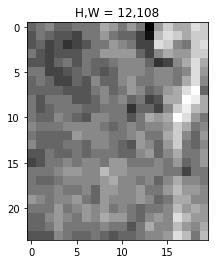

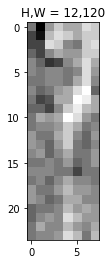

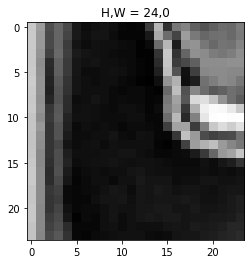

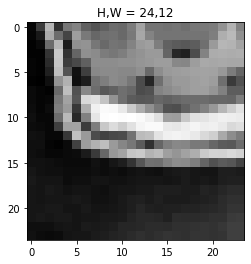

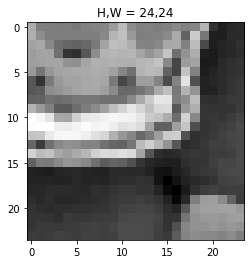

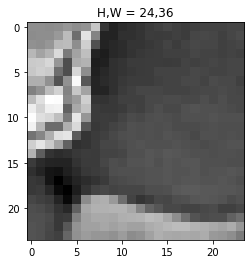

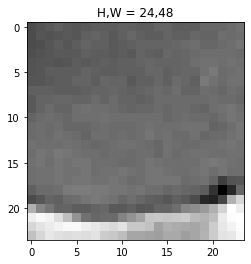

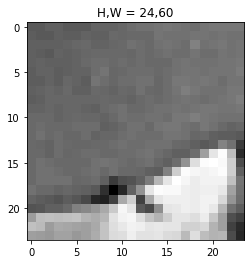

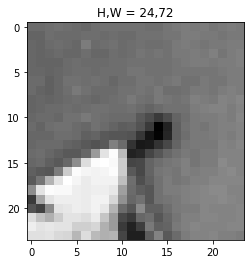

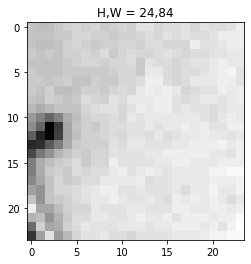

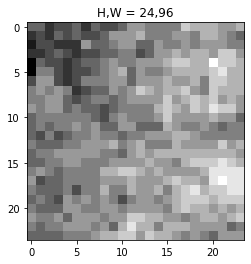

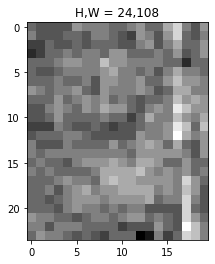

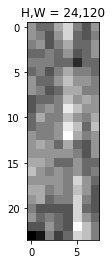

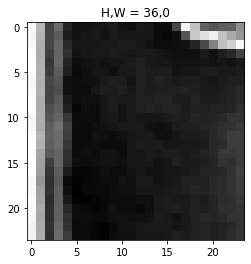

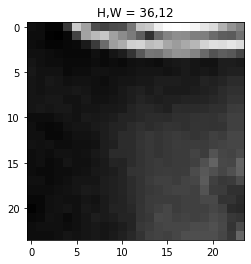

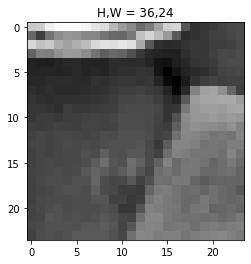

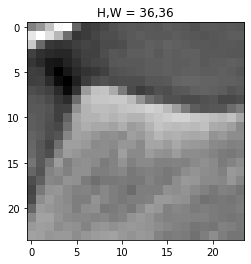

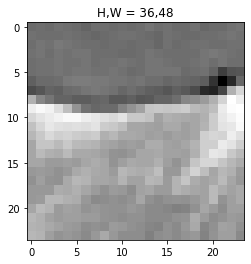

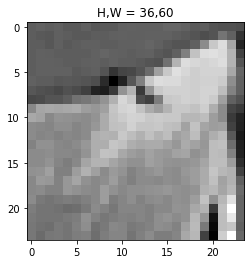

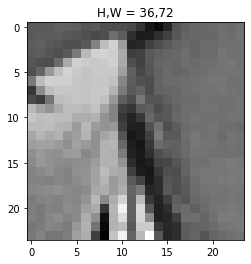

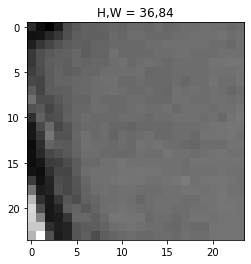

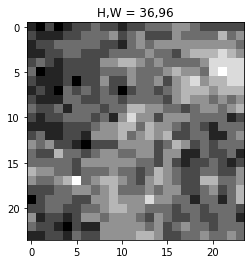

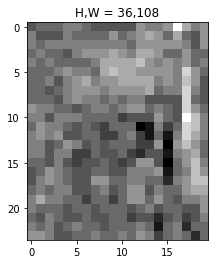

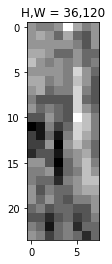

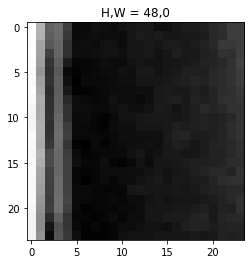

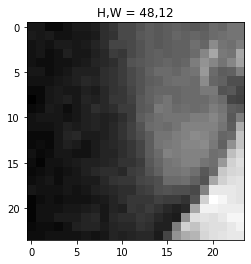

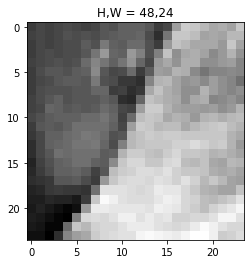

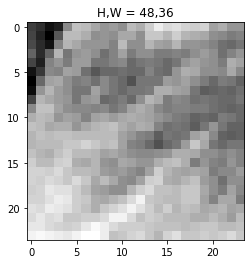

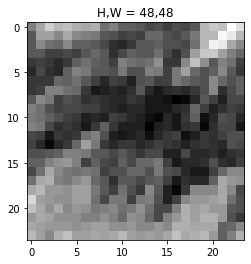

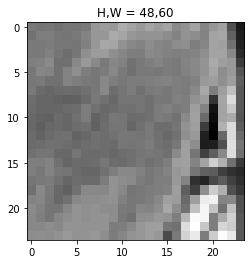

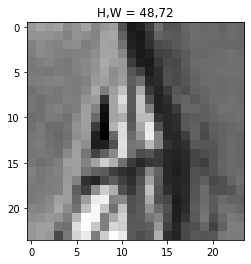

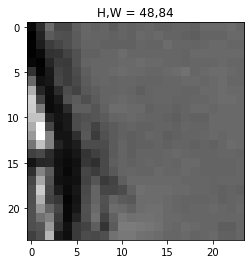

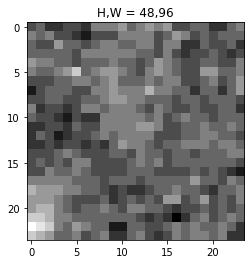

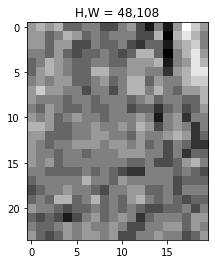

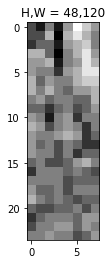

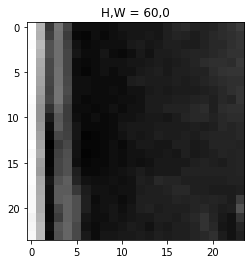

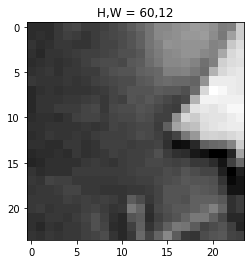

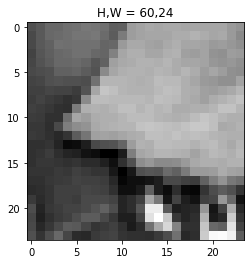

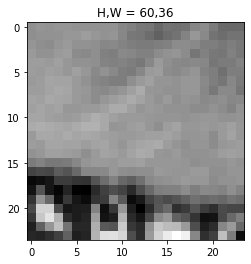

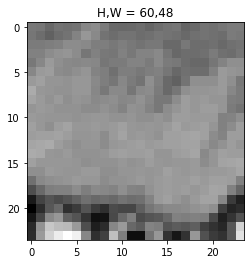

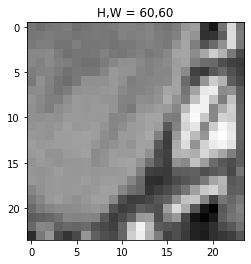

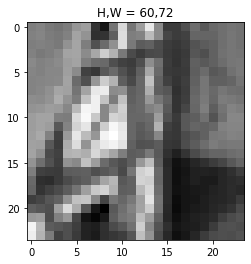

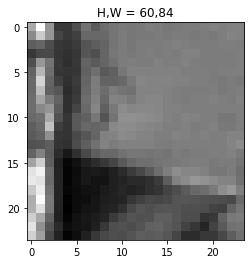

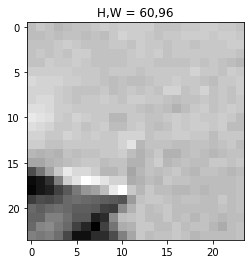

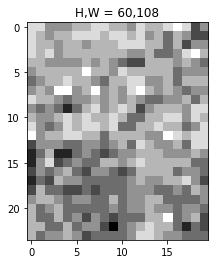

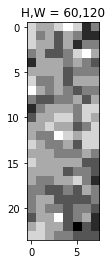

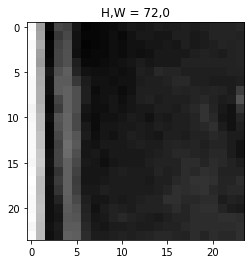

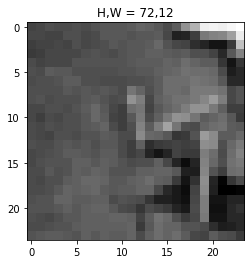

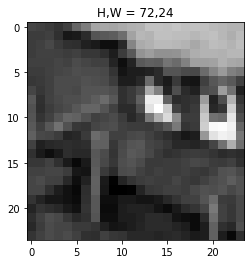

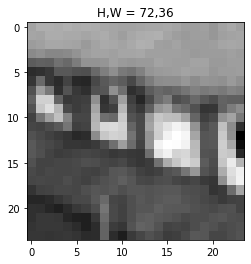

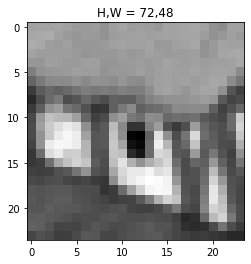

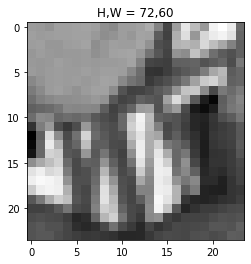

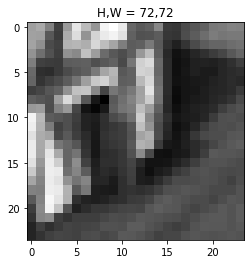

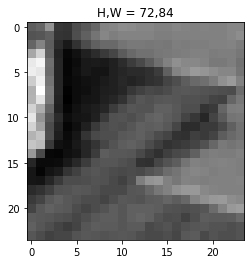

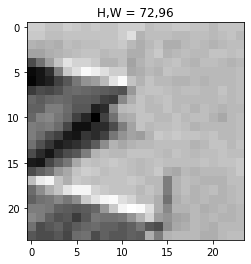

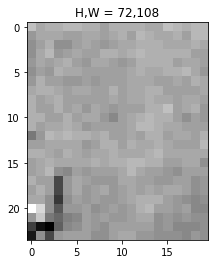

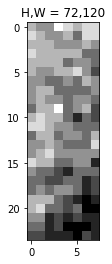

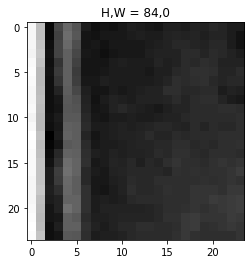

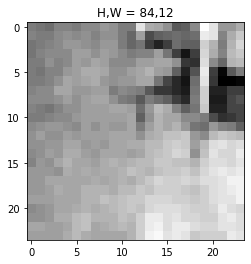

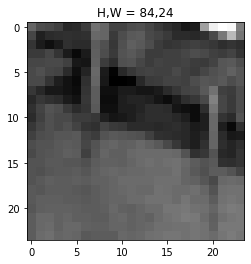

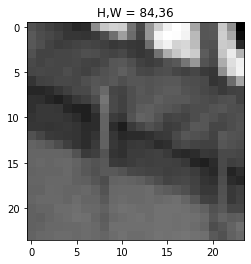

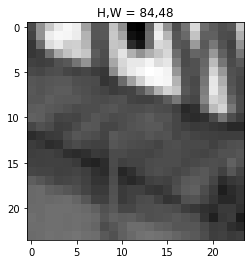

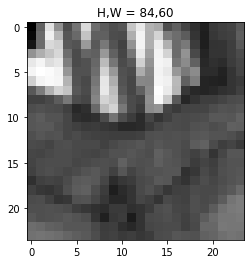

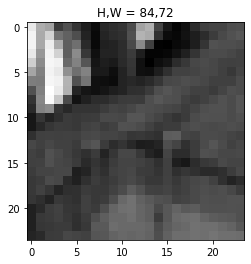

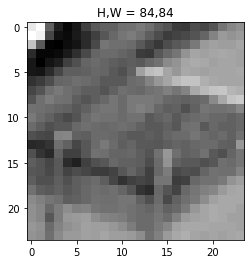

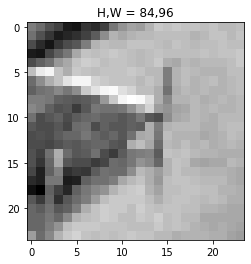

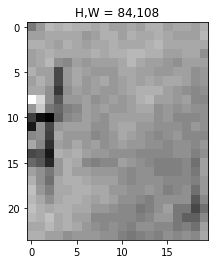

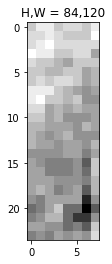

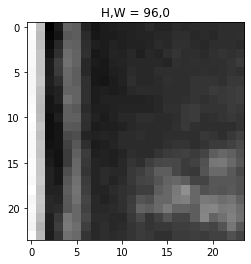

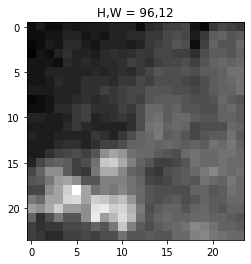

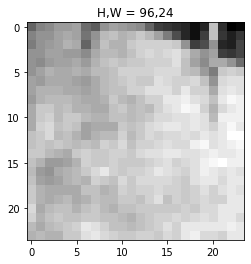

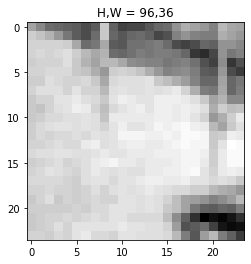

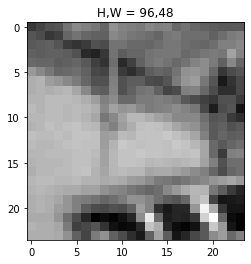

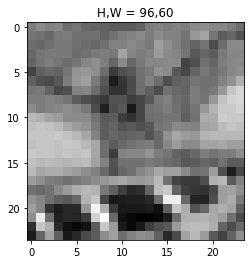

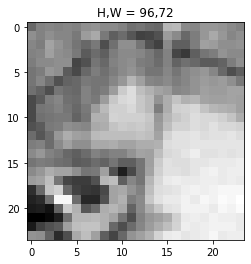

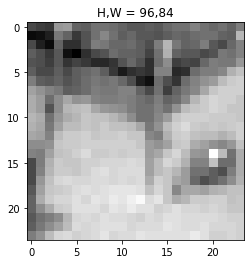

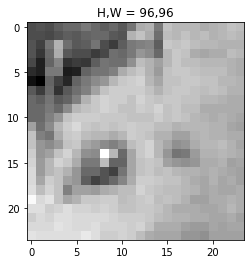

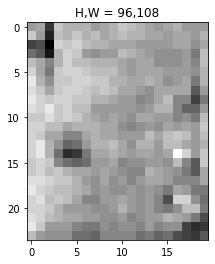

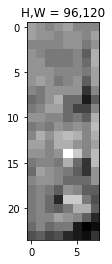

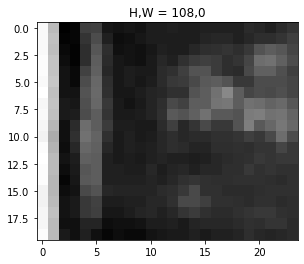

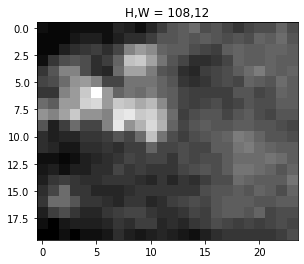

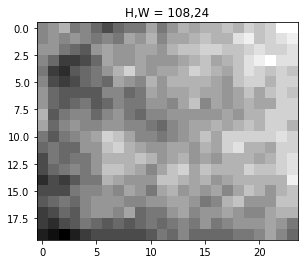

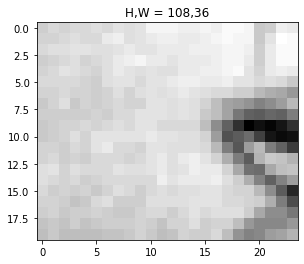

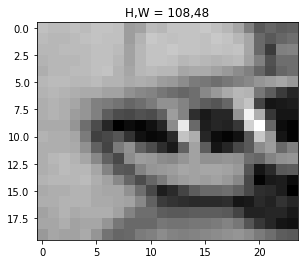

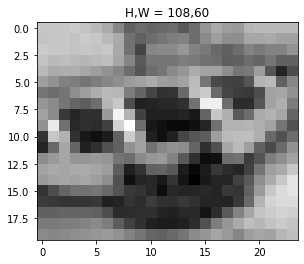

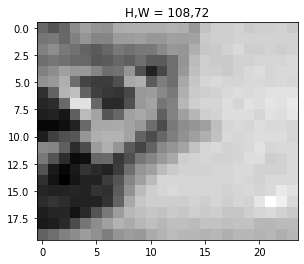

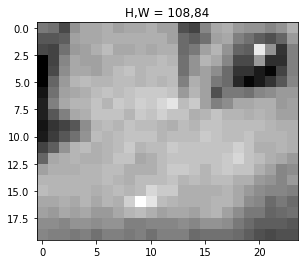

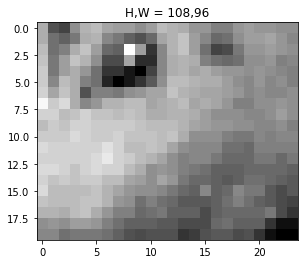

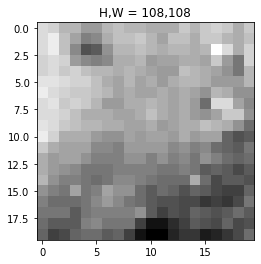

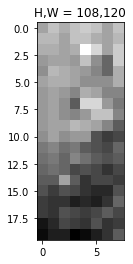

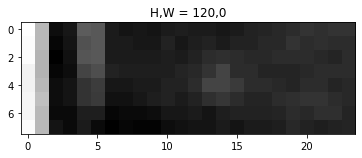

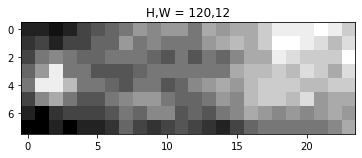

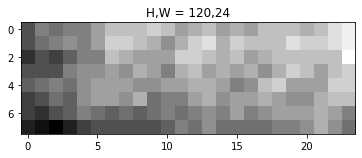

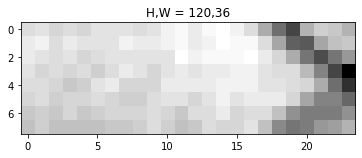

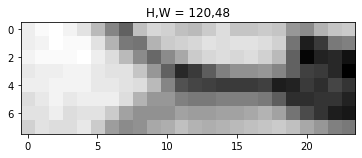

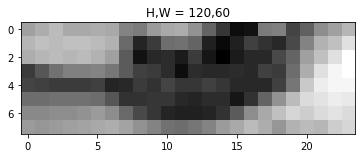

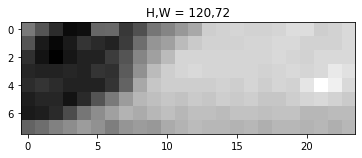

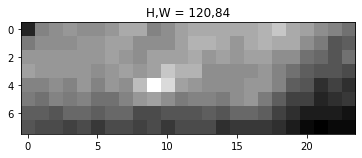

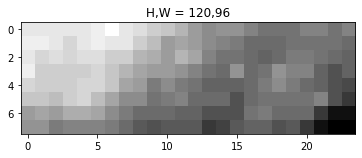

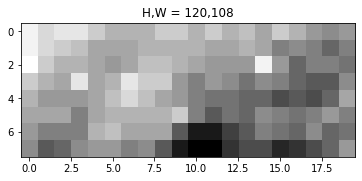

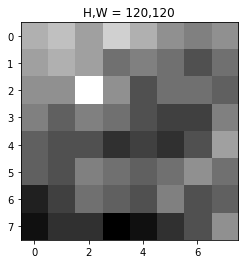

In [241]:
for h in range(0, H, 12):
    for w in range(0, W, 12):
        block = example[h:(h+24), w:(w+24)]
        plt.figure()
        plt.title("H,W = {0},{1}".format(h,w))
        plt.imshow(block, cmap="gray")